In [1]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
import matplotlib.pyplot as plt

In [2]:
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [3]:
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

In [4]:
model.base_model.config

BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [5]:
pytorch_total_params = sum(p.numel() for p in model.base_model.parameters() if p.requires_grad)    
pytorch_trainable_params = sum(p.numel() for p in model.base_model.parameters() )    
print("Total number of params", pytorch_total_params)
print("Total number of trainable params", pytorch_trainable_params)

Total number of params 334092288
Total number of trainable params 334092288


In [6]:
text = r"""Japan is the eleventh-most populous country in the world, as well as one of the most densely populated and urbanized.
 About three-fourths of the country's terrain is mountainous, concentrating its population of 125.57 million on narrow coastal plains. 
 Japan is divided into 47 administrative prefectures and eight traditional regions.
 Osaka has a big population of 16 million. 
 The Greater Tokyo Area is the most populous metropolitan area in the world, with more than 37.4 million residents. 
"""

In [7]:
import numpy as np
def get_top_answers(possible_starts,possible_ends,input_ids):
    answers = []
    for start,end in zip(possible_starts,possible_ends):
    #+1 for end
        answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[start:end+1]))
        answers.append( answer )
    return answers  

def answer_question(question,context,topN):

    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt")
    
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    model_out = model(**inputs)
     
    answer_start_scores = model_out["start_logits"]
    answer_end_scores = model_out["end_logits"]

    possible_starts = np.argsort(answer_start_scores.cpu().detach().numpy()).flatten()[::-1][:topN]
    possible_ends = np.argsort(answer_end_scores.cpu().detach().numpy()).flatten()[::-1][:topN]
    
    #get best answer
    answer_start = torch.argmax(answer_start_scores)  
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    answers = get_top_answers(possible_starts,possible_ends,input_ids )  #to extract only top related answers

    return { "answer":answer,"answer_start":answer_start,"answer_end":answer_end,"input_ids":input_ids,
            "answer_start_scores":answer_start_scores,"answer_end_scores":answer_end_scores,"inputs":inputs,"answers":answers,
            "possible_starts":possible_starts,"possible_ends":possible_ends}

In [8]:
questions = [
    "How many states in Japan?",
    "What is the population of Japan?",
    "Which city is most crowded in the world?",
    "What is the city with most population?",
    "What is the topic here?",
    "What are we talking about?",
    "What is the main idea here?"
]

In [9]:
for q in questions:
    answer_map = answer_question(q,text,5)    
    print("Question:",q)
    print("Answers:")
    [print((index+1)," ) ",ans) for index,ans in  enumerate(answer_map["answers"]) if len(ans) > 0 ]

Question: How many states in Japan?
Answers:
1  )  47
2  )  japan is divided into 47 administrative prefectures and eight traditional regions
3  )  eleventh - most populous country in the world, as well as one of the most densely populated and urbanized. about three - fourths of the country's terrain is mountainous, concentrating its population of 125. 57 million on narrow coastal plains. japan is divided into 47 administrative prefectures
4  )  eight traditional regions.
5  )  divided into 47 administrative prefectures and eight
Question: What is the population of Japan?
Answers:
1  )  125. 57 million
2  )  japan is the eleventh - most populous country in the world, as well as one of the most densely populated and urbanized. about three - fourths of the country's terrain is mountainous, concentrating its population of 125. 57
3  )  population of 125. 57 million on narrow coastal plains
5  )  eleventh - most populous country in the world, as well as one of the most densely populated an

In [10]:
answer_map = answer_question("Where is most populous in the world?",text,3)

In [11]:
print("input_ids:",answer_map["inputs"]["input_ids"] )
print("token_type_ids:",answer_map["inputs"]["token_type_ids"] )
print("attention_mask:",answer_map["inputs"]["attention_mask"] )
#answer_map["inputs"]

input_ids: tensor([[  101,  2073,  2003,  2087, 20151,  1999,  1996,  2088,  1029,   102,
          2900,  2003,  1996, 11911,  1011,  2087, 20151,  2406,  1999,  1996,
          2088,  1010,  2004,  2092,  2004,  2028,  1997,  1996,  2087, 19441,
         10357,  1998,  3923,  3550,  1012,  2055,  2093,  1011,  2959,  2015,
          1997,  1996,  2406,  1005,  1055,  9291,  2003, 14897,  1010, 16966,
          2049,  2313,  1997,  8732,  1012,  5401,  2454,  2006,  4867,  5780,
          8575,  1012,  2900,  2003,  4055,  2046,  4700,  3831,  7498,  2015,
          1998,  2809,  3151,  4655,  1012, 13000,  2038,  1037,  2502,  2313,
          1997,  2385,  2454,  1012,  1996,  3618,  5522,  2181,  2003,  1996,
          2087, 20151,  4956,  2181,  1999,  1996,  2088,  1010,  2007,  2062,
          2084,  4261,  1012,  1018,  2454,  3901,  1012,   102]])
token_type_ids: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1,

In [12]:
print( len(answer_map["input_ids"] ))
tokenizer.decode( answer_map["input_ids"] ) 

108


"[CLS] where is most populous in the world? [SEP] japan is the eleventh - most populous country in the world, as well as one of the most densely populated and urbanized. about three - fourths of the country's terrain is mountainous, concentrating its population of 125. 57 million on narrow coastal plains. japan is divided into 47 administrative prefectures and eight traditional regions. osaka has a big population of 16 million. the greater tokyo area is the most populous metropolitan area in the world, with more than 37. 4 million residents. [SEP]"

In [13]:
def plot_possible_answer(answer_map,expected_start,expected_end):
    start_scores = answer_map["answer_start_scores"]
    end_scores = answer_map["answer_end_scores"]
    tokens = tokenizer.decode( answer_map["input_ids"] ).split(" ") 
    print("tokens",len(tokens),"---",len(answer_map["input_ids"]))
    tokens_ind = [ tokenizer.decode(t) for t in answer_map["input_ids"] ]
    print("tokens_ind",len(tokens_ind))
    fig,axes = plt.subplots(2,1)
    y_start = start_scores.detach().numpy().flatten()
    x_start = [i for i in range(len(y_start))]

    y_end = end_scores.detach().numpy().flatten()
    x_end = [i for i in range(len(y_end))]

    axes[0].bar(tokens_ind,y_start)
    axes[0].set_title("start scores( "+ str( len( y_start ) ) +")" )
    axes[0].figure.set_size_inches(20, 5)
    #axes[0].xaxis.set_labels( tokens_ind )
    axes[0].xaxis.set_tick_params(rotation=90)
    axes[0].axvline(expected_start,color="yellow")

    axes[1].bar(tokens_ind,y_end, color="orange")
    axes[1].set_title("end scores( "+ str( len( y_end ) ) +")" )
    axes[1].axvline(expected_end,color="red")
    axes[1].xaxis.set_tick_params(rotation=90)

    axes[0].autoscale(tight=True)
    axes[1].autoscale(tight=True)
    fig.tight_layout()

tokens 92 --- 108
tokens_ind 108


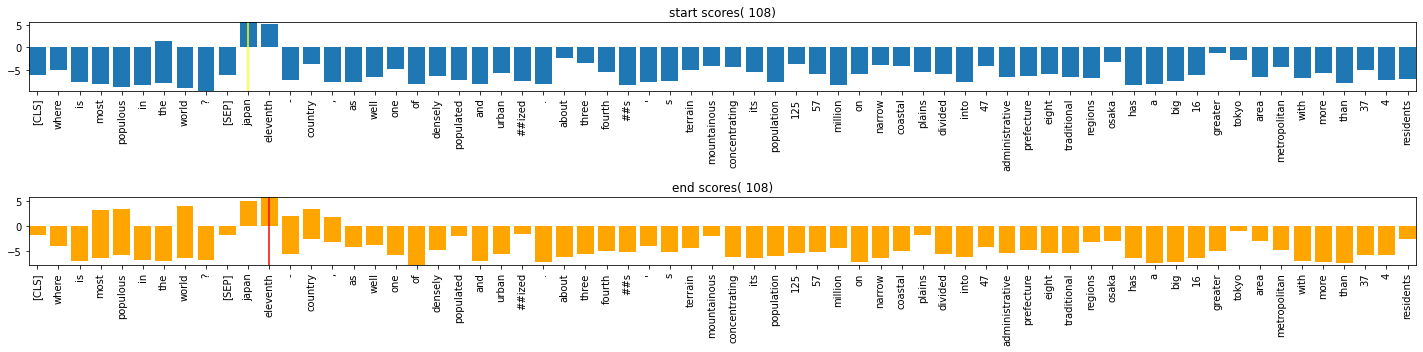

In [14]:
plot_possible_answer(answer_map,10,11)